Cross Matching with EPIC
==============

Given a list of K2 sources it is important to be able to match consistently against the Ecliptic Plane Input Catalog (EPIC). Good cross matching ensures that each target has a unique identifier and reductions from different teams can be compared. 

To find the best cross matches we must do the following.

* Cross match each target against Ecliptic Plane Input Catalog (EPIC) to find the nearest neighbors, up to some depth
* Find a probabilistic way of determining the best, unique match for every target
* Decide what probability threshold to set to determine which are matches are acceptable.

The EPIC catalog can be downloaded from MAST [here](https://archive.stsci.edu/missions/k2/catalogs/). (In this case I have downloaded the catalog and reduced it to only cover Campaign 2 to slightly improve speed.) Using astropy's crossmatching functions it is easy to find the nearest neighbors. The function below will match the EPIC against the input catalog up a number of nearest neighbors specified by 'depth'.

In [ ]:
import xmatch
xmatch.match('C02_master_merged.fits',depth=5)

There are two pieces of information which would help us with the cross matching. 

 * **dist**: The distance to the best matching source in EPIC
 * **magnitude**: The magnitude of the source

Lower magnitude sources should in general have slightly more uncertainty in the cross match radius. By creating a probability that takes magnitude into account we can be more tolerant of slightly poorer matches for faint sources. This is particularly important in K2 C02 where there are many reddened sources which are more uncertain in EPIC.

To find good matches we have to find the most probable match out of the 5 nearest targets, based on distance and magnitude. To do this we have to find some way of assigning a probability to each target.

We can do this by modeling the two different distributions of **magnitude** and **distance**. This distribution is shown below. We can model it with a simple 2D Gaussian (shown in red). Assuming that most of the sources have fairly good matches to the EPIC, we can use this distribution to give us a probability of a match.

We have two flat priors. 
* While there are fewer targets with very short cross match distances, this is due to low numbers of objects. Sources with a very short cross match radius should have a high probability.
* While there are fewer bright targets, this is also mostly due to low number statistics. Bright targets do have slightly larger cross match radii, due to saturation in EPIC.

Including these flat priors we find the orange distribution for targets.


<img src=images/gri_model.png style="width: 500px;">

Now for any give **distance** and **magnitude** we can have a relative probability. Comparison of this probability should tell us which target is the best match out of the 5.

The probability of all 5 of the nearest neighbors for all targets are shown below. The thresholds have been chosen to classify sources as 'matches' (yellow) , 'soft matches' and 'missing' (purple). The soft matches are where the source is particularly faint or far.

<img src=images/prob.png style="width: 500px;">


Out of the 5 possible matches we now pick the match that is the most likely. In all but a handful of cases this is the nearest neighbor. We then look for any duplicates, find which of the set of duplicates has the highest probability and reassign the rest. (This is iterative until all targets have been assigned the most likely, unique match.)

We can highlight targets that are crowded by finding targets with sources in EPIC within a few Kepler pixels. 

We can then look for blends, where the target in the input catalog is between two sources in EPIC. These are not truly bad matches but ones where the one or both of the catalogs are probably inaccurate. Examples crowded and blended targets are below.

<table>
<tr>
<td><img src=images/blended_example.png style="width: 500px;"></td>
<td><img src=images/crowded_example.png style="width: 500px;"></td>
</tr>
</table>

The benefit of this method is being able to choose a probability threshold to cut between 'good' and 'bad' matches, rather than distance. (These thresholds are chosen by eye based on star maps like the one above.) Running this matching routine we find 

* 16364 matched sources ( 90.81 %)
* 1596 soft matches (508  of which are blended sources)
* 306 missing sources
* 5981 crowded sources


All hard and soft matches have the best match EPIC ID. However for the soft matches, particularly the blends it would be worth checking the match more closely. Missing sources have no matching EPIC ID and require a new ID.

<img src=images/distprob.png style="width: 500px;">

As shown above, a similar result could be found by having a cut in cross match radius. The addition of magnitude information adds little. A distance cut would make a very similar catalog.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
results=pd.read_pickle('results_probabilities.p')

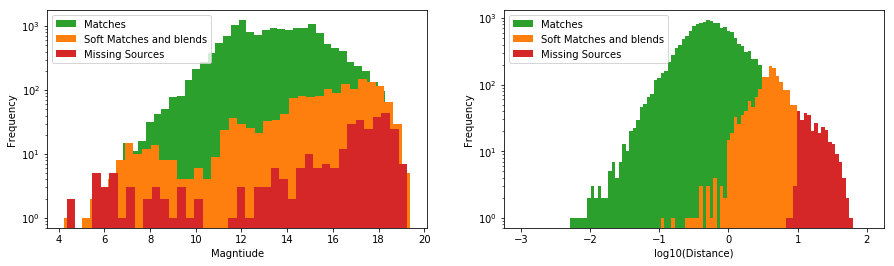

In [48]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(results.InputMag[results.xmatch==1],40,color='C2',label='Matches')
_=ax[0].hist(results.InputMag[results.xmatch==0.5],40,color='C1',label='Soft Matches and blends')
_=ax[0].hist(results.InputMag[results.xmatch==0],40,color='C3',label='Missing Sources')
ax[0].legend()
ax[0].set_xlabel('Magntiude')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')

h=ax[1].hist(np.log10(results.EPICd2d[results.xmatch==1]),bins=np.linspace(-3,2,100),color='C2',label='Matches')
_=ax[1].hist(np.log10(results.EPICd2d[results.xmatch==0.5]),h[1],color='C1',label='Soft Matches and blends')
_=ax[1].hist(np.log10(results.EPICd2d[results.xmatch==0]),h[1],color='C3',label='Missing Sources')
ax[1].legend()
ax[1].set_xlabel('log10(Distance)')
ax[1].set_ylabel('Frequency')
ax[1].set_yscale('log')

Using dmagnitude instead of magnitude
--------------------------------------
It is possible to use the change in magnitude instead of the magnitude of the source. Similarly this adds little to the cross match ability. There is one benefit that sources that have very different magnitudes than those in EPIC (variables and young stars) are more easily flagged. 

Using KEPFLAG keyword
---------------------
It is possible to use the KEPFLAG keyword to find two distributions. KEPFLAG gives what photometric band was used to add that source to the EPIC. The flag can have values of *gri, J, JHK* or *BV*. *gri* matches have better magnitude and distance estimates than others. It is possible to create two distributions, one for *gri* targets and one for non *gri* targets. All sources can then be compared. However, this causes a large number of sources to be misclassified where it is more likely that a faint, distant , non *gri* source is a better match than a close *gri* source. Adding the KEPFLAG keyword does not significantly improve the cross match.

Running
-------

The above script can be run with the same thresholds using the following call

In [ ]:
xmatch.fit()